# Recommender System using Spark

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, StringType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
from operator import add
import time
import csv
import re
from tempfile import NamedTemporaryFile

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline



In [2]:
spark = SparkSession \
.builder \
.appName("cite") \
.config("spark.memory.fraction", 0.8) \
.config("spark.executor.memory", "14g") \
.config("spark.driver.memory", "12g")\
.config("spark.sql.shuffle.partitions" , "800") \
.config("spark.driver.maxResultSize",  0) \
.getOrCreate()

sc = spark.sparkContext


# Loading Data onto Dataframes

In [3]:
# loading the schema as mentioned in the README 
papersSchema = StructType([
    StructField("paper_id", StringType(), False),
    StructField("type", StringType(), True),
    StructField("journal", StringType(), True),
    StructField("book_title", StringType(), True),
    StructField("series", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("pages", IntegerType(), True),
    StructField("volume", IntegerType(), True),
    StructField("number", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("postedat", IntegerType(), True),
    StructField("address", StringType(), True),
    StructField("title", StringType(), True),
    StructField("abstract", StringType(), True)
])
# load csv data onto the DF
papersDf = spark.read.csv("papers.csv", header = False, schema = papersSchema).select('paper_id', 'abstract')

papersTermsSchema = StructType([
    StructField("paper_id", IntegerType(), False),
    StructField("terms", StringType(), False)
])

# loading the users usersLibraries schema as mentioned in the README
usersLibrariesSchema = StructType([
    StructField("user_hash_id", StringType(), False),
    StructField("user_library", StringType(), False)
])
# load data into dataframe
usersLibrariesDf = spark.read.csv("users_libraries.txt", sep = ";", header = False, schema = usersLibrariesSchema)
usersLibrariesDf = usersLibrariesDf.select(usersLibrariesDf.user_hash_id, 
                                           F.split(usersLibrariesDf.user_library,',').alias('user_library_arr'))

# Advanced Analysis
## Sparsity of the Rating Matrix
The ratings matrix is a sparse matrix of size (number_users, number_items). The values are populated as 1 for the paper_ids for which user has given a rating as in usersLibrariesDf. Hence, the number of non zero entries per user is the size of the  The formula of calculation is as follows:

$$sparsity = 1 - \frac{number\_of\_non\_zero\_entries}{size\_of\_the\_matrix}$$

$$sparsity = 1 - \frac{number\_of\_non\_zero\_entries}{(number\_of\_users)(number\_of\_items)}$$

The number\_of\_non\_zero\_entries is same as the the 

In [4]:
# generate and select a column containing the length (size) of the user library array - number of ratings given by each user
usersRatingsCountsDf = usersLibrariesDf.select(F.size('user_library_arr').alias('number_ratings'))

# the non-zero entries will be formed by user ratings - total number of user ratings = sum of all the ratings given by users 
number_of_non_zero_entries = usersRatingsCountsDf.agg({'number_ratings': 'sum'}).collect()[0][0]

number_of_users = usersLibrariesDf.count()

number_of_items = papersDf.count()

sparsity = 1 - number_of_non_zero_entries/(number_of_users*number_of_items)
print(f"Sparsity of the rank matrix: {sparsity}")

Sparsity of the rank matrix: 0.9998305694442852


## rank-frequency distribution of users and ratings

We already created a dataframe with the counts of ratings per user (usersRatingsCountsDf).
To generate the rank, we will need to sort the dataframe wrt the number_ratings column in descending order 


<AxesSubplot:>

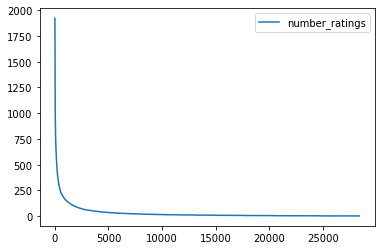

In [5]:
usersRatingsCountsDf.sort('number_ratings', ascending = False).toPandas().plot.line(y='number_ratings')

## rank-frequency distribution of items and ratings


<AxesSubplot:>

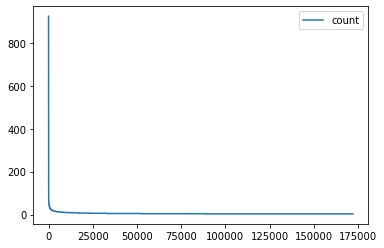

In [6]:
# We first need to segregate the user library into individual rows containing each item 
explodedUsersLibrariesDf = usersLibrariesDf.select('user_hash_id', F.explode('user_library_arr').alias('item'))

# We now need to generate a count of ratings recieved by each time 
# which is equal to the number of times the item appears in the dataframe
itemRatingsCountDf = explodedUsersLibrariesDf.groupBy('item').count()

# We now generate the rank by sorting the the dataframe in a descending order and plot the same 
itemRatingsCountDf.sort('count', ascending=False).toPandas().plot.line(y='count')

<b>After plotting we clearly see a long tail representative of a power function</b>

# Ratings Matrix Preparation

The ALS algorithm accepts only integer ids. Hence, we need to convert both user_hash_id and paper_id to integer ids. 
We now need to generate a ratingsMatrixDf contaning 1 against the paper_ids present in the user library and 0 for the rest of papers.

To generate the paper_ids not in user library, we need to perform array difference between an array of all the paper_ids and the user_library_arr for each user.

The list of all paper_ids is generated by the function collect_list which collects all the values of a column into a list. (in allPaperIdsDf)

This list is added as the column 'all_paper_ids' into the papersDf by joining it with allPaperIdsDf.

The negative_library (list of paper_ids not in to user_library_arr) is generated by calculating the difference between all_paper_ids column and user_library_arr. This is done using the spark aggregator function 'array_except'

The positiveRatings are generated by exploding the user_library_arr into separate rows and rating all the paper_ids as 1. This is done using the spark function 'lit(1)' which adds a column to the dataframe and initializes it with the value 1 for every row in the dataframe.

The negativeRatings are generated similarly by exploding the negative_library into separate rows and rating all the paper_ids as 0. 

ratingsMatrix can be calculated by generating a union of positiveRatings and negativeRatings, containing the 'rating' column with 1 and 0 respectively


In [7]:
# A lookup table specifying a mapping from hash_id to the integer user_id
userIdsLookupDf = usersLibrariesDf.select("user_hash_id").distinct()
w = Window.orderBy("user_hash_id")
userIdsLookupDf = userIdsLookupDf.withColumn("user_id", F.row_number().over(w))

# A lookup table for mapping the numerical paper ids (paper_id_num) to paper_id 
paperIdsLookupDf = papersDf.drop("abstract").distinct()
w = Window.orderBy("paper_id")
paperIdsLookupDf = paperIdsLookupDf.withColumn("paper_id_num", F.row_number().over(w))

# collecting all paper_ids from papersDf into a list as a single-element dataframe with column 'all_paper_ids'
allPaperIdsDf = papersDf.select(F.collect_list('paper_id').alias('all_paper_ids'))

# joining 'all_paper_ids' into the userLibrariesDf 
usersLibrariesAllDf = usersLibrariesDf.join(allPaperIdsDf)

# creating negative_library with the paper_ids not in the user_library_arr
usersLibrariesAllDf = usersLibrariesAllDf.withColumn('negative_library', F.array_except('all_paper_ids', 'user_library_arr'))
usersLibrariesAllDf = usersLibrariesAllDf.drop('all_paper_ids')

# user_hash_id, paper_id, rating (1 for every row)
positiveRatingsDf = usersLibrariesAllDf.select('user_hash_id', F.explode('user_library_arr').alias('paper_id'), F.lit(1).alias('rating'))
# user_hash_id, paper_id, rating (0 for every row)
negativeRatingsDf = usersLibrariesAllDf.select('user_hash_id', F.explode('negative_library').alias('paper_id'), F.lit(0).alias('rating'))

# user_hash_id, paper_id, rating (1 for paper_ids in user_library and 0 for others)
ratingsMatrixDf = positiveRatingsDf.union(negativeRatingsDf)
# user_id (integer user_hash_id), paper_id, rating
ratingsMatrixDf = ratingsMatrixDf.join(userIdsLookupDf, ratingsMatrixDf.user_hash_id == userIdsLookupDf.user_hash_id).select('user_id', 'paper_id', 'rating')
# user_id, paper_id_num (integer paper_id), rating 
ratingsMatrixDf = ratingsMatrixDf.join(paperIdsLookupDf, ratingsMatrixDf.paper_id == paperIdsLookupDf.paper_id).select('user_id', 'paper_id_num', 'rating')
print(ratingsMatrixDf.show())

+-------+------------+------+
|user_id|paper_id_num|rating|
+-------+------------+------+
|   4471|       88743|     1|
|   4471|      108106|     1|
|   4471|      117759|     1|
|   4471|       96609|     1|
|   4471|      117145|     1|
|   4471|      103092|     1|
|   4471|      126282|     1|
|   4471|      126283|     1|
|   4471|      105418|     1|
|   4471|       79790|     1|
|   4471|       94546|     1|
|   4471|       76595|     1|
|   4471|      120297|     1|
|   4471|       96617|     1|
|   4471|      113456|     1|
|   4471|      103276|     1|
|   4471|      120440|     1|
|   4471|       95307|     1|
|   4471|      117898|     1|
|   4471|      100321|     1|
+-------+------------+------+
only showing top 20 rows

None


# ALS algorithm
Fitting the als model and generating the recommendations for all users.

In [1]:
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=2, rank=10, regParam=0.01, userCol='user_id', itemCol='paper_id_num', ratingCol='rating', coldStartStrategy="drop")

model = als.fit(ratingsMatrixDf)

usersRecommendations = model.recommendForAllUsers(10)

In order to retrieve the recommendations, we need the user_id corresponding to the user_hash_id. We use the followng user_hash_id as an example

In [ ]:
user_hash_id = "1eac022a97d683eace8815545ce3153f"

# retrieve the user_id corresponding to the user_hash_id
user_id = userIdsLookupDf.filter(userIdsLookupDf.user_hash_id == user_hash_id).select('user_id').first()[0]

#retrieve the recommendations for the user with user_id
print(usersRecommendations.filter(usersRecommendations.user_id == user_id).collect())

## Model Evaulation
### Splitting into training and test sets

In [ ]:
(trainingDf, testDf) = ratingsMatrixDf.randomSplit([0.7, 0.3])

### Fitting the model on the training set 

In [ ]:
ALSmodel = als.fit(trainingDf)

### RMSE calculation
Root mean square error (RMSE) is calculated by evaluating the model predictions on the testDf using the RegressionEvaluator.

In [ ]:
predictions = model.transform(testDf)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse} ")

##  Hyperparameter tuning 

In [ ]:
# parameter grid fixing the predictionCol and maxIter with varying values for rank
paramGrid = ParamGridBuilder() \
    .baseOn({als.predictionCol: 'prediction'})\
    .baseOn({als.maxIter: 2})\
    .addGrid(als.rank, [10,25,50]) \
    .build()

# setting up cross validator with appropriate inputs
crossval_rank = CrossValidator()  
  .setEstimator(als)
  .setEvaluator(evaluator)
  .setEstimatorParamMaps(paramGrid)
  .setNumFolds(5)

# fitting the model on cross validator
crossval_model_rank = crossval_rank.fit(trainingDf)

# retrieving the best performing model and the corresponding rank
best_model_rank = crossval_model_rank.bestModel
best_rank = best_model.getRank()
print(f"The rank giving the best performnce: {best_rank}")

# evaluating the best model and computing rmse for it
predictions = best_model_rank.transform(testDf)
rmse = evaluator.evaluate(prediction)
print(f"The RMSE on the test dataframe using the best rank ({best_rank}): {rmse}")


Fixing rank to the best value obtained in the previous step and increasing maxIter.


In [ ]:
paramGridMaxIter = ParamGridBuilder() \
    .baseOn({als.predictionCol: 'prediction'}) \
    .baseOn({als.rank: best_rank}) \
    .addGrid(als.maxIter, [2,3,4,5]) \
    .build()
   
crossval_maxIter = CrossValidator()  
  .setEstimator(als)
  .setEvaluator(evaluator)
  .setEstimatorParamMaps(paramGridMaxIter)
  .setNumFolds(5)

crossval_model_maxIter = crossval_maxIter.fit(trainingDf)

best_model_maxIter = crossval_model_rank.bestModel
best_maxIter = best_model.getRank()

<b>Increasing the maxIter doesn't have any effect on the performance.</b>